1)

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import fashion_mnist

In [57]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [58]:
X_train_full.shape,y_train_full.shape

((60000, 28, 28), (60000,))

In [59]:
names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

In [60]:
names #we keep only classes 0,1,2

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [61]:
keep=np.isin(y_train_full,[0, 1, 2])

In [62]:
X=X_train_full[keep]
y=y_train_full[keep]

In [63]:
X.shape,y.shape

((18000, 28, 28), (18000,))

In [175]:
X_scaled = X.astype(np.float32) / 127.5 - 1.0

In [176]:
X_scaled.shape

(18000, 28, 28)

In [177]:
X_scaled.dtype

dtype('float32')

2)

In [198]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Reshape
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.regularizers import l1 
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [199]:
generator=Sequential([
        Dense(100, activation='relu', kernel_initializer='he_normal',input_shape=(30,)),
        Dense(150, activation='relu', kernel_initializer='he_normal'),
        Dense(784, activation='tanh'),
        Reshape((28, 28))
    ])

3)

In [200]:
discriminator = Sequential([
    Flatten(),
    Dense(150, activation='relu', kernel_initializer='he_normal'),
    Dense(100, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

4)

In [209]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [210]:
discriminator.trainable = False

In [211]:
gan=Sequential([generator, discriminator])

In [212]:
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [213]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_scaled)
dataset = dataset.shuffle(1000).batch(batch_size, drop_remainder=True).prefetch(1)

In [214]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [215]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}") 
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

Epoch 1/10


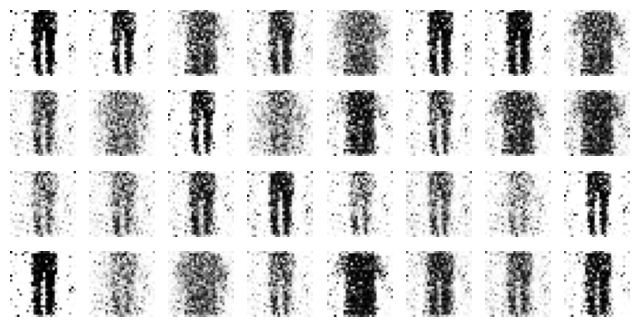

Epoch 2/10


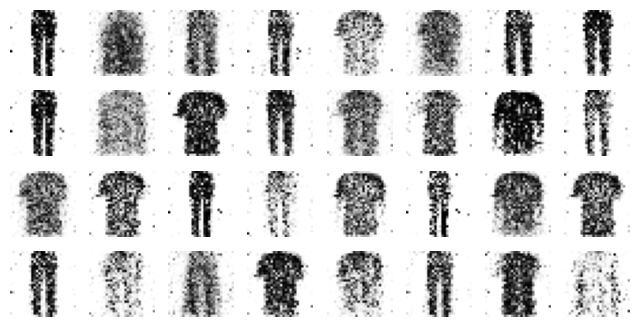

Epoch 3/10


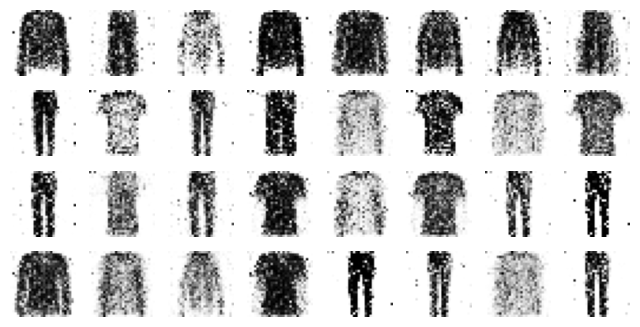

Epoch 4/10


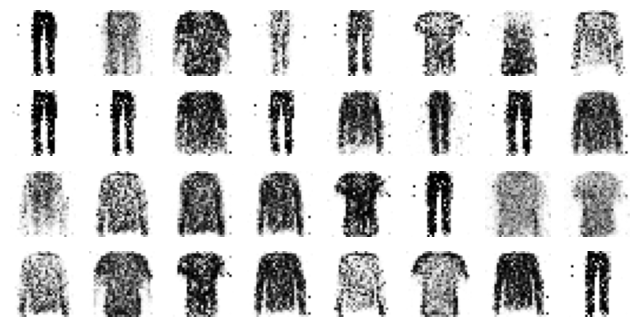

Epoch 5/10


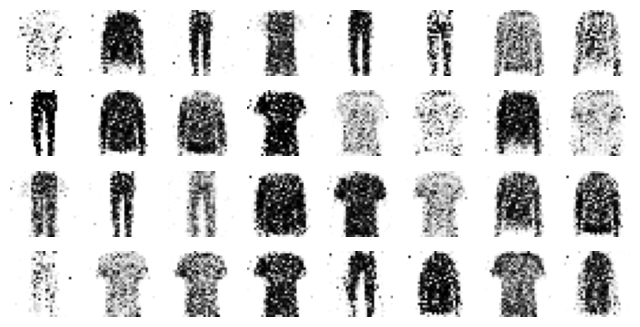

Epoch 6/10


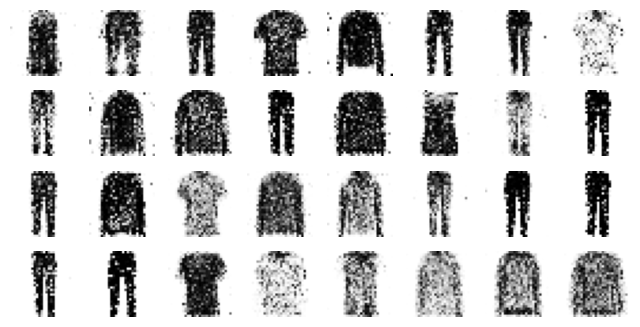

Epoch 7/10


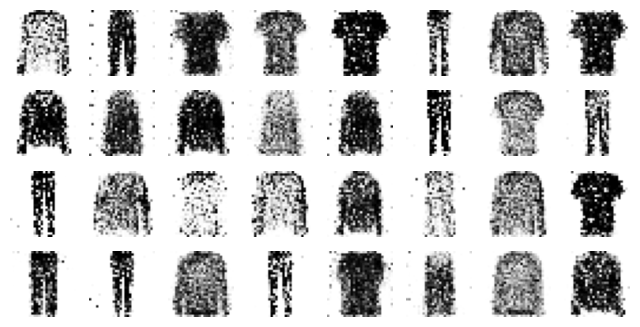

Epoch 8/10


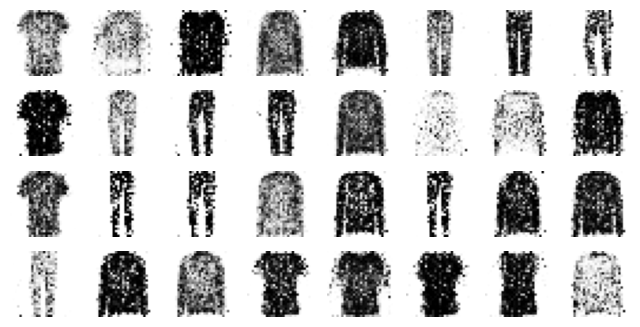

Epoch 9/10


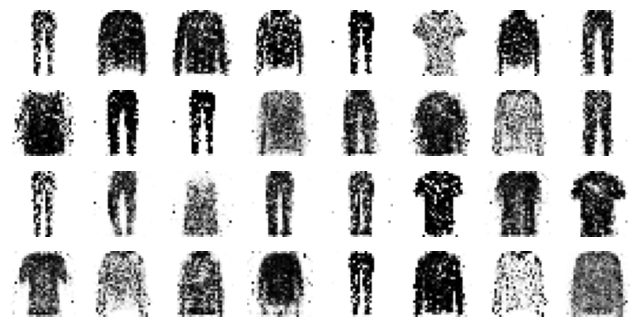

Epoch 10/10


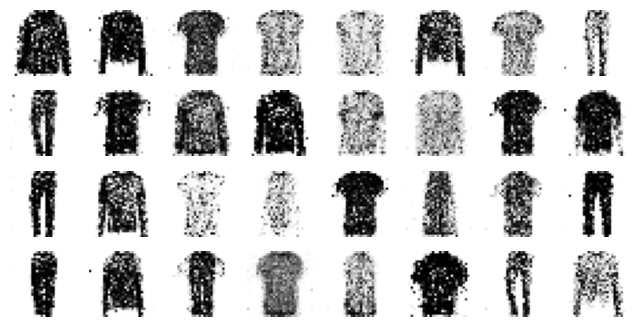

In [216]:
train_gan(gan, dataset, batch_size, codings_size=30, n_epochs=10)

In [218]:
codings = tf.random.normal(shape=[batch_size, 30])
generated_images = generator.predict(codings)

1/1 [==============================] - 0s 155ms/step


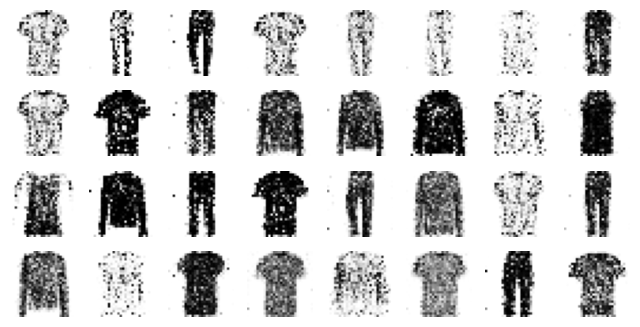

In [219]:
plot_multiple_images(generated_images, 8)

6)

In [220]:
def evaluate_discriminator(generator, discriminator, noise_dim=30, num_images=32):
    noise = np.random.normal(0, 1, (num_images, noise_dim))
    generated_images = generator.predict(noise, verbose=0)
    fake_labels = np.zeros((num_images, 1))
    predictions = discriminator.predict(generated_images, verbose=0)
    predicted_classes = (predictions < 0.5).astype(int)
    accuracy = np.mean(predicted_classes == fake_labels)
    print(f"Discriminator accuracy on final generated images: {accuracy * 100:.2f}%")
    return accuracy

evaluate_discriminator(generator, discriminator)


Discriminator accuracy on final generated images: 37.50%


0.375